With this project, I plan to use Google BigQuery to extract, transform and visualize data from an api called _AlphaVantage_ which is a finance api.

The steps involved in this project are:
- Get data from the api
- Save data in database in google BigQuery
- Process the data to use just the relavant data
- Visualize resulting data

## Import necessary libraries

In [1]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

from pyspark.sql import SparkSession
from pyspark.sql.functions import *

from google.cloud import bigquery
from google.oauth2 import service_account

import requests

import datetime

import seaborn as sns
import matplotlib.pyplot as plt

## Get the stock option you are interested in

In [2]:
# Get the stock options data from the API
stock_options = pd.read_csv(filepath_or_buffer=f"listing_status.csv")
stock_options_values = stock_options['name'].dropna().unique().tolist()

# Define a combo box widget for the stock options
stock_option_name_widget = widgets.Combobox(placeholder='Choose a stock',
                                         options=stock_options_values,
                                            description='Stock:',
                                            ensure_option=True,
                                            disabled=False)
stock_option_symbol_widget = widgets.Label(value="")

# Define a function to update the stock option symbol
def update_stock_option_symbol(change):
    stock_option_symbol_widget.value = stock_options[stock_options['name'] == change.new]['symbol'].values[0]

# Observing the change in the stock option name
stock_option_name_widget.observe(update_stock_option_symbol, names='value')

# Display the widgets horizontally
widgets.HBox([stock_option_name_widget,stock_option_symbol_widget])


## Create a connection to google bigquery

In [3]:
# if stock_option_symbol_widget.value == "" choose a default value
if stock_option_symbol_widget.value == "":
    stock_option_symbol_widget.value = "AAPL"

In [4]:
API_KEY = f"YSX1MOJ9YMQUJ6TI"
DATE    = datetime.datetime.now().strftime("%Y_%m_%d")
CHOICE  = "TIME_SERIES_DAILY"#_ADJUSTED"
URL     = f"https://www.alphavantage.co/query?function={CHOICE}&symbol={stock_option_symbol_widget.value}&outputsize=full&apikey={API_KEY}&datatype=csv"
FNAME   = f"{stock_option_symbol_widget.value}_Daily_{DATE}.csv"

# Path to the service account key file
SERVICE_ACCOUNT_KEY_PATH =  "etl-1-393004-fd0ba98bf9de.json"

# Create credentials object from the service account key file
credentials = service_account.Credentials.from_service_account_file(SERVICE_ACCOUNT_KEY_PATH)

# Create a bigquery client object
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

In [5]:
# Check if this dataset already exists
dataset_id  = "stock_market_data"
dataset_ref = client.dataset(dataset_id)
try:
    client.get_dataset(dataset_ref)
    print(f"Dataset {dataset_id} already exists")
except:
    print(f"Dataset {dataset_id} does not exist")
    # Create a the dataset
    dataset = bigquery.Dataset(dataset_ref)
    dataset = client.create_dataset(dataset)
    print(f"Dataset {dataset_id} created")

Dataset stock_market_data already exists


In [6]:
# Check if this table already exists if not create it
table_id  = f"{stock_option_symbol_widget.value}_{DATE}"
table_ref = dataset_ref.table(table_id)
try:
    client.get_table(table_ref)
    print(f"Table {table_id} already exists")
    # Recreate the table
    client.delete_table(table_ref)
    print(f"Table {table_id} deleted")
    table = bigquery.Table(table_ref)
    table = client.create_table(table)
    print(f"Table {table_id} created")
except:
    print(f"Table {table_id} does not exist")
    # Create the table
    table = bigquery.Table(table_ref)
    table = client.create_table(table)
    print(f"Table {table_id} created")

Table AAPL_2023_07_21 already exists
Table AAPL_2023_07_21 deleted
Table AAPL_2023_07_21 created


### Get the data from the API

In [7]:
# Get the data
stock_data = pd.read_csv(filepath_or_buffer=URL)

In [8]:
# Connect to google bigQuery, and load the data into the table
job_config = bigquery.LoadJobConfig()
job_config.autodetect = True
job_config.skip_leading_rows = 1
job_config.source_format = bigquery.SourceFormat.CSV

job = client.load_table_from_dataframe(dataframe  = stock_data, 
                                       destination= table_ref, 
                                       job_config = job_config)
job.result()

LoadJob<project=etl-1-393004, location=US, id=a73032b2-ef08-4e81-b418-f1b4fa2466a9>

In [9]:
# Check if the data was loaded
table = client.get_table(table_ref)
print(f"Loaded {table.num_rows} rows into {table_id}")  # Loaded 100 rows into stock_market_data.AAPL_2021-05-28

Loaded 5966 rows into AAPL_2023_07_21


In [10]:
# Print the table schema and the first five rows
print("Table schema:")
print(table.schema)
print("Table data:")
display(client.list_rows(table, max_results=5).to_dataframe())

Table schema:
[SchemaField('timestamp', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('open', 'FLOAT', 'NULLABLE', None, None, (), None), SchemaField('high', 'FLOAT', 'NULLABLE', None, None, (), None), SchemaField('low', 'FLOAT', 'NULLABLE', None, None, (), None), SchemaField('close', 'FLOAT', 'NULLABLE', None, None, (), None), SchemaField('volume', 'INTEGER', 'NULLABLE', None, None, (), None)]
Table data:


,timestamp,open,high,low,close,volume
0,2003-01-27,13.68,14.5,13.65,14.13,6989400
1,2002-09-10,14.41,14.5,14.12,14.33,4454800
2,2003-02-27,14.57,15.0,14.51,14.86,2756100
3,2003-01-07,14.79,15.0,14.47,14.85,6113300
4,2002-08-02,14.74,15.0,14.25,14.45,3197500


Explaining each column in the data
1. Open: The opening price of the stock for the day
2. High: The highest price of the stock for the day
3. Low: The lowest price of the stock for the day
4. Close: The closing price of the stock for the day
5. Adjusted Close: The closing price of the stock for the day, adjusted for corporate actions
6. Volume: The number of shares traded for the day
7. Dividend Amount: The dividend paid by the company for the day
8. Split Coefficient: The ratio of the stock split. 2 means 2 shares for the cost of 1

Currently, I'm interested in the Adjusted Close and the Volume which can be used to draw a fast conclusion on which stocks are profitable.

In [11]:
# Create a new table to keep only the columns we need: timestamp, adjusted_close, volume and close
table_id  = f"{stock_option_symbol_widget.value}_{DATE}_clean"
table_ref = dataset_ref.table(table_id)
try:
    client.get_table(table_ref)
    print(f"Table {table_id} already exists")
except:
    print(f"Table {table_id} does not exist")
    # Create the table
    table = bigquery.Table(table_ref)
    table = client.create_table(table)
    print(f"Table {table_id} created")

# Load the data into the new table from the previous table
job_config = bigquery.LoadJobConfig()
job_config.autodetect = True
job_config.skip_leading_rows = 1
job_config.source_format = bigquery.SourceFormat.CSV

job = client.load_table_from_dataframe(stock_data[['timestamp','volume','close']], table_ref, job_config=job_config)
job.result()

# Check if the data was loaded
table = client.get_table(table_ref)
print(f"Loaded {table.num_rows} rows into {table_id}")  # Loaded 100 rows into stock_market_data.AAPL_2021-05-28

# Look at the table schema and the first five rows
table = client.get_table(table_ref)
print("Table schema:")
print(table.schema)
print("Table data:")
display(client.list_rows(table, max_results=5).to_dataframe())

Table AAPL_2023_07_21_clean already exists
Loaded 29830 rows into AAPL_2023_07_21_clean
Table schema:
[SchemaField('timestamp', 'STRING', 'NULLABLE', None, None, (), None), SchemaField('volume', 'INTEGER', 'NULLABLE', None, None, (), None), SchemaField('close', 'FLOAT', 'NULLABLE', None, None, (), None)]
Table data:


,timestamp,volume,close
0,2000-12-19,6678700,14.0
1,2003-02-26,3876700,14.5
2,2002-09-30,4244600,14.5
3,2002-09-16,5118600,14.5
4,2003-03-21,5320500,15.0


In [43]:
# Fetch data from the _clean table and create a new table with a new column which splits the volume into 5 bins

bins  = [702500, 1000000, 2000000, 3000000, 332607163]
query = f"SELECT timestamp, close, volume, \
          CASE \
                WHEN volume <= {bins[0]} THEN '< 1M' \
                WHEN volume > {bins[0]} AND volume <= {bins[1]} THEN '1M - 2M' \
                WHEN volume > {bins[1]} AND volume <= {bins[2]} THEN '2M - 3M' \
                WHEN volume > {bins[2]} AND volume <= {bins[3]} THEN '3M - 4M' \
                                      ELSE '> 4M'  END AS volume_band \
          FROM  {client.project}.{dataset_id}.{stock_option_symbol_widget.value}_{DATE}_clean;"

query_job = client.query(query)

df = query_job.to_dataframe()

# Convert the timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(type(df['timestamp'][0]))

# Filter the data to get a single value for each day
df = df.groupby(['timestamp','volume_band']).mean().reset_index()

display(display(df['volume_band'].value_counts()), display(df[df['volume_band'] == '< 1M']))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


volume_band
> 4M       5815
3M - 4M     126
2M - 3M      23
1M - 2M       1
< 1M          1
Name: count, dtype: int64

,timestamp,volume_band,close,volume
790,2002-12-24,< 1M,14.36,702500.0


None

None

In [44]:
plt.rcParams.update({'font.weight':'light', 'font.family':'monospace'})
plt.rcParams['axes.labelcolor']= '#fff'
plt.rcParams['text.color']  = '#fff'
plt.rcParams['xtick.color'] = '#fff'
plt.rcParams['ytick.color'] = '#fff'

In [45]:
def scale(x, lower=0, upper=1):
    return ((x-np.min(x))/(np.max(x)-np.min(x)))*(upper-lower)+lower

alpha = scale(df['close'], 0.4, .9)
sizes = scale(df['volume'], 1, 10).tolist()
# Set colors for the volume bands as contrasting colors
colors = sns.color_palette("husl", 5)
# Create an array with colors for each row for volume_band
colors = [colors[i] for i in df['volume_band'].map({'< 1M':0, '1M - 2M':1, '2M - 3M':2, '3M - 4M':3, '> 4M':4})]

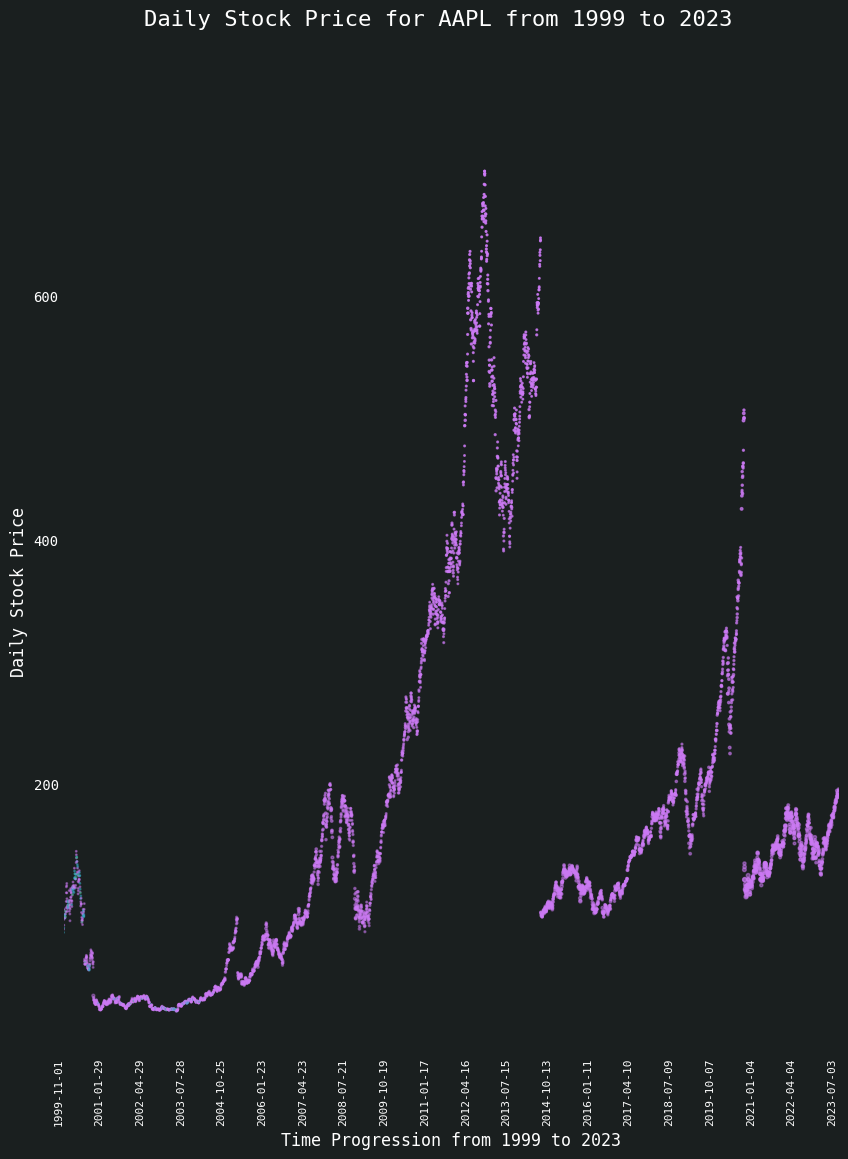

In [54]:
BKGRD_CLR = "#1a1f1f"
CLR = "#fff"

# Create a chart with the data
fig, ax = plt.subplots(figsize=(10,12))
# Remove spines
ax.set_frame_on(False)

##orange
# Calculate the number of days between the minimum and maximum timestamp values
days_range = (df['timestamp'].max() - df['timestamp'].min()).days

# Calculate the step size for the ticks to show 10 evenly spaced ticks
step_size = int(days_range / 19)  # 9 intervals for 10 ticks

# Set the tick positions and labels for the x-axis
tick_positions = pd.date_range(start=df['timestamp'].min(), end=df['timestamp'].max(), freq=f'{step_size}D')
tick_labels = [date.strftime('%Y-%m-%d') for date in tick_positions]

# Customize limits and tick positions for the x-axis
ax.set_xlim([df['timestamp'].min(), df['timestamp'].max()])
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontdict={'fontsize': 8})

# Set x-axis label
ax.set_xlabel(f"Time Progression from {df['timestamp'].min().year} to {df['timestamp'].max().year}", 
              fontdict={'fontsize': 12, 'fontweight': 'light', 'color': CLR})
## 

# Customize tick positions and labels for the y-axis
ax.set_yticks([200, 400, 600])
ax.set_yticklabels([200, 400, 600], fontdict={'fontsize': 10})

# Set y-axis label
ax.set_ylabel("Daily Stock Price", fontdict={'fontsize': 12, 'fontweight': 'light', 'color': CLR})

# Remove tick marks
ax.tick_params(length=0)

# Set background color
fig.patch.set_facecolor(BKGRD_CLR)
fig.set_facecolor(BKGRD_CLR)
ax.set_facecolor(BKGRD_CLR)

# Rotate the x-axis labels
plt.xticks(rotation=90)

# Plot a scatterplot with ax instead of sns to have more control over the plot elements and colors 
ax.scatter(x = df['timestamp'], 
           y = df['close'],
           c = colors,
           s = sizes,
           alpha = alpha)

# Add a title
fig.suptitle(f"Daily Stock Price for {stock_option_symbol_widget.value} from {df['timestamp'].min().year} to {df['timestamp'].max().year}",
                fontsize=16, 
                fontweight='light', 
                color=CLR)

# Save the figure
fig.savefig(f"{stock_option_symbol_widget.value}_Daily_{DATE}.jpg", facecolor=fig.get_facecolor(), edgecolor='none')